In [199]:
import pandas as pd
import numpy as np
import ast
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.decomposition import TruncatedSVD

In [200]:
archivoOrg = "data/gen/cleaned.csv"
df = pd.read_csv(archivoOrg)
df.head(20)

,ANO_EMISION,MES_EMISION,DIA_EMISION,REG_MCPIO,QUIEN_REPORTA,VIC_SEXO,VIC_EDAD,TOTAL_HIJOS,NUM_HIJ_HOM,NUM_HIJ_MUJ,...,AGR_OTROS_N_OS,AGR_OTRAS_N_AS,INST_DENUN_HECHO,LEY_APLICABLE,FECHA_EMISION,FECHA_HECHO,REG_DPTO,HEC_DPTO,MEDIDAS_SEGURIDAD,CONTEXTO_DE_VIC
0,2013,1,22,guatemala,Víctima,Mujeres,38.0,2,1,1,...,0.0,0.0,Organismo Judicial,Ambas leyes (VIF y VCM),2013-01-22,2013-01-19,guatemala,guatemala,Dto. 22-2008,2
1,2013,1,24,guatemala,Víctima,Mujeres,20.0,1,0,1,...,99.0,99.0,Ministerio Público,NaN,2013-01-24,2013-01-23,guatemala,guatemala,Dto. 22-2008,2
2,2013,1,21,guatemala,Víctima,Mujeres,21.0,2,1,1,...,99.0,99.0,Procuraduría de los Derechos Humanos,NaN,2013-01-21,2013-01-21,guatemala,guatemala,Dto. 22-2008,1
3,2013,1,2,guatemala,Víctima,Hombres,70.0,0,0,0,...,99.0,99.0,Procuraduría de los Derechos Humanos,NaN,2013-01-02,2013-01-02,guatemala,guatemala,Dto. 97-96,3
4,2013,1,10,guatemala,Víctima,Mujeres,36.0,99,99,99,...,99.0,99.0,Procuraduría de los Derechos Humanos,NaN,2013-01-10,2013-01-10,guatemala,guatemala,Dto. 22-2008,2
5,2013,1,15,guatemala,Víctima,Mujeres,56.0,0,0,0,...,99.0,99.0,Procuraduría de los Derechos Humanos,NaN,2013-01-15,2013-01-15,guatemala,guatemala,Dto. 22-2008,0
6,2013,1,11,guatemala,Víctima,Mujeres,42.0,99,99,99,...,99.0,99.0,Procuraduría de los Derechos Humanos,NaN,2013-01-11,2013-01-11,guatemala,guatemala,Dto. 22-2008,1
7,2013,1,11,guatemala,Víctima,Mujeres,33.0,0,0,0,...,99.0,99.0,Procuraduría de los Derechos Humanos,NaN,2013-01-11,2013-01-11,guatemala,guatemala,Dto. 22-2008,0
8,2013,1,2,guatemala,Víctima,Mujeres,46.0,1,0,1,...,99.0,99.0,Procuraduría de los Derechos Humanos,NaN,2013-01-02,2013-01-01,guatemala,guatemala,Dto. 22-2008,1
9,2013,1,3,guatemala,Víctima,Mujeres,42.0,99,99,99,...,99.0,99.0,Procuraduría de los Derechos Humanos,NaN,2013-01-03,2013-01-03,guatemala,guatemala,Dto. 22-2008,1


In [201]:
df['FECHA_EMISION'] = pd.to_datetime(df['FECHA_EMISION'])
df['FECHA_HECHO'] = pd.to_datetime(df['FECHA_HECHO'])
df['FECHA_ENTRE_EMISION_HECHO'] = (df['FECHA_EMISION'] - df['FECHA_HECHO']).dt.days


In [202]:
nuevas_columnas = [
    'VIC_REL_AGR', 'HEC_TIPAGRE', 'CONTEXTO_DE_VIC', 'MEDIDAS_SEGURIDAD', 
    'FECHA_ENTRE_EMISION_HECHO', 'TOTAL_HIJOS', 'NUM_HIJ_HOM', 
    'NUM_HIJ_MUJ', 'OTRAS_VICTIMAS', 'VIC_OTRAS_HOM', 'VIC_OTRAS_MUJ', 
    'VIC_OTRAS_N_OS', 'VIC_OTRAS_N_AS', 'AGRESORES_OTROS_TOTAL', 
    'AGR_OTROS_HOM', 'AGR_OTRAS_MUJ', 'AGR_OTROS_N_OS', 'AGR_OTRAS_N_AS', 'HEC_RECUR_DENUN'
]
df['HEC_TIPAGRE'] = df['HEC_TIPAGRE'].apply(ast.literal_eval)
nuevo_df = df[nuevas_columnas].copy()
nuevo_df.head()

,VIC_REL_AGR,HEC_TIPAGRE,CONTEXTO_DE_VIC,MEDIDAS_SEGURIDAD,FECHA_ENTRE_EMISION_HECHO,TOTAL_HIJOS,NUM_HIJ_HOM,NUM_HIJ_MUJ,OTRAS_VICTIMAS,VIC_OTRAS_HOM,VIC_OTRAS_MUJ,VIC_OTRAS_N_OS,VIC_OTRAS_N_AS,AGRESORES_OTROS_TOTAL,AGR_OTROS_HOM,AGR_OTRAS_MUJ,AGR_OTROS_N_OS,AGR_OTRAS_N_AS,HEC_RECUR_DENUN
0,Esposos(a),"[física, psicológica]",2,Dto. 22-2008,3.0,2,1,1,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,No
1,Conviviente,"[física, psicológica, patrimonial]",2,Dto. 22-2008,1.0,1,0,1,99,99.0,99.0,99.0,99.0,99,99.0,99.0,99.0,99.0,No
2,Ex-cónyuges,"[física, psicológica, patrimonial]",1,Dto. 22-2008,0.0,2,1,1,2,0.0,0.0,1.0,1.0,99,99.0,99.0,99.0,99.0,No
3,Esposos(a),[psicológica],3,Dto. 97-96,0.0,0,0,0,0,0.0,0.0,0.0,0.0,99,99.0,99.0,99.0,99.0,No
4,Esposos(a),"[psicológica, sexual, patrimonial]",2,Dto. 22-2008,0.0,99,99,99,1,0.0,0.0,1.0,0.0,99,99.0,99.0,99.0,99.0,No


In [203]:
df_exploded = df.explode('HEC_TIPAGRE')

dummies = pd.get_dummies(df_exploded['HEC_TIPAGRE'], prefix='TipoAgre')

df_exploded = df_exploded.join(dummies)

df_final = df_exploded.groupby(df_exploded.index)[dummies.columns].max(numeric_only=False)*1


cols = ['VIC_REL_AGR', 'CONTEXTO_DE_VIC', 'MEDIDAS_SEGURIDAD', 
                     'FECHA_ENTRE_EMISION_HECHO', 'TOTAL_HIJOS', 'NUM_HIJ_HOM', 
                     'NUM_HIJ_MUJ', 'OTRAS_VICTIMAS', 'VIC_OTRAS_HOM', 'VIC_OTRAS_MUJ', 
                     'VIC_OTRAS_N_OS', 'VIC_OTRAS_N_AS', 'AGRESORES_OTROS_TOTAL', 
                     'AGR_OTROS_HOM', 'AGR_OTRAS_MUJ', 'AGR_OTROS_N_OS', 'AGR_OTRAS_N_AS','HEC_RECUR_DENUN']

for col in cols:
    df_final[col] = df.loc[df.index.isin(df_final.index), col]

df_final = df_final[[*cols, *dummies.columns]]
df_final.head()

,VIC_REL_AGR,CONTEXTO_DE_VIC,MEDIDAS_SEGURIDAD,FECHA_ENTRE_EMISION_HECHO,TOTAL_HIJOS,NUM_HIJ_HOM,NUM_HIJ_MUJ,OTRAS_VICTIMAS,VIC_OTRAS_HOM,VIC_OTRAS_MUJ,...,AGRESORES_OTROS_TOTAL,AGR_OTROS_HOM,AGR_OTRAS_MUJ,AGR_OTROS_N_OS,AGR_OTRAS_N_AS,HEC_RECUR_DENUN,TipoAgre_física,TipoAgre_patrimonial,TipoAgre_psicológica,TipoAgre_sexual
0,Esposos(a),2,Dto. 22-2008,3.0,2,1,1,0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,No,1,0,1,0
1,Conviviente,2,Dto. 22-2008,1.0,1,0,1,99,99.0,99.0,...,99,99.0,99.0,99.0,99.0,No,1,1,1,0
2,Ex-cónyuges,1,Dto. 22-2008,0.0,2,1,1,2,0.0,0.0,...,99,99.0,99.0,99.0,99.0,No,1,1,1,0
3,Esposos(a),3,Dto. 97-96,0.0,0,0,0,0,0.0,0.0,...,99,99.0,99.0,99.0,99.0,No,0,0,1,0
4,Esposos(a),2,Dto. 22-2008,0.0,99,99,99,1,0.0,0.0,...,99,99.0,99.0,99.0,99.0,No,0,1,1,1


In [204]:
def convertir_columnas(valor):
    if valor == 0:
        return 'Si'
    elif valor > 0 and valor != 99:
        return 'No'
    elif valor == 99:
        return 'Desconocido'
    else:
        return valor

In [205]:

df_final['HAY_HIJOS'] = df_final['TOTAL_HIJOS'].apply(convertir_columnas)
df_final['HAY_HIJOS_HOM'] = df_final['NUM_HIJ_HOM'].apply(convertir_columnas)
df_final['HAY_HIJOS_MUJ'] = df_final['NUM_HIJ_MUJ'].apply(convertir_columnas)
df_final['HAY_OTRAS_VIC'] = df_final['OTRAS_VICTIMAS'].apply(convertir_columnas)
df_final['HAY_OTRAS_VIC_HOM_MENORES'] = df_final['VIC_OTRAS_N_OS'].apply(convertir_columnas)
df_final['HAY_OTRAS_VIC_MUJ_MENORES'] = df_final['VIC_OTRAS_N_AS'].apply(convertir_columnas)
df_final['HAY_OTROS_AGR'] = df_final['AGRESORES_OTROS_TOTAL'].apply(convertir_columnas)

columnas_originales = ['VIC_REL_AGR', 'CONTEXTO_DE_VIC', 'MEDIDAS_SEGURIDAD',
                       'FECHA_ENTRE_EMISION_HECHO', 'HEC_RECUR_DENUN',
                       'TipoAgre_física', 'TipoAgre_patrimonial',
                       'TipoAgre_psicológica', 'TipoAgre_sexual']

nuevo_df = df_final[['HAY_HIJOS', 'HAY_HIJOS_HOM', 'HAY_HIJOS_MUJ', 'HAY_OTRAS_VIC',
               'HAY_OTRAS_VIC_HOM_MENORES', 'HAY_OTRAS_VIC_MUJ_MENORES', 'HAY_OTROS_AGR'] + columnas_originales].copy()

nuevo_df.head()


,HAY_HIJOS,HAY_HIJOS_HOM,HAY_HIJOS_MUJ,HAY_OTRAS_VIC,HAY_OTRAS_VIC_HOM_MENORES,HAY_OTRAS_VIC_MUJ_MENORES,HAY_OTROS_AGR,VIC_REL_AGR,CONTEXTO_DE_VIC,MEDIDAS_SEGURIDAD,FECHA_ENTRE_EMISION_HECHO,HEC_RECUR_DENUN,TipoAgre_física,TipoAgre_patrimonial,TipoAgre_psicológica,TipoAgre_sexual
0,No,No,No,Si,Si,Si,Si,Esposos(a),2,Dto. 22-2008,3.0,No,1,0,1,0
1,No,Si,No,Desconocido,Desconocido,Desconocido,Desconocido,Conviviente,2,Dto. 22-2008,1.0,No,1,1,1,0
2,No,No,No,No,No,No,Desconocido,Ex-cónyuges,1,Dto. 22-2008,0.0,No,1,1,1,0
3,Si,Si,Si,Si,Si,Si,Desconocido,Esposos(a),3,Dto. 97-96,0.0,No,0,0,1,0
4,Desconocido,Desconocido,Desconocido,No,No,Si,Desconocido,Esposos(a),2,Dto. 22-2008,0.0,No,0,1,1,1


In [206]:
df_encoded = pd.get_dummies(nuevo_df, columns=['VIC_REL_AGR', 'MEDIDAS_SEGURIDAD', 'HEC_RECUR_DENUN', 'HAY_HIJOS', 'HAY_HIJOS_HOM','HAY_HIJOS_MUJ','HAY_OTRAS_VIC',	'HAY_OTRAS_VIC_HOM_MENORES','HAY_OTRAS_VIC_MUJ_MENORES','HAY_OTROS_AGR'])
df_encoded.head()

,CONTEXTO_DE_VIC,FECHA_ENTRE_EMISION_HECHO,TipoAgre_física,TipoAgre_patrimonial,TipoAgre_psicológica,TipoAgre_sexual,VIC_REL_AGR_Conviviente,VIC_REL_AGR_Esposos(a),VIC_REL_AGR_Ex-cónyuges,VIC_REL_AGR_Hermanos(as),...,HAY_OTRAS_VIC_Si,HAY_OTRAS_VIC_HOM_MENORES_Desconocido,HAY_OTRAS_VIC_HOM_MENORES_No,HAY_OTRAS_VIC_HOM_MENORES_Si,HAY_OTRAS_VIC_MUJ_MENORES_Desconocido,HAY_OTRAS_VIC_MUJ_MENORES_No,HAY_OTRAS_VIC_MUJ_MENORES_Si,HAY_OTROS_AGR_Desconocido,HAY_OTROS_AGR_No,HAY_OTROS_AGR_Si
0,2,3.0,1,0,1,0,False,True,False,False,...,True,False,False,True,False,False,True,False,False,True
1,2,1.0,1,1,1,0,True,False,False,False,...,False,True,False,False,True,False,False,True,False,False
2,1,0.0,1,1,1,0,False,False,True,False,...,False,False,True,False,False,True,False,True,False,False
3,3,0.0,0,0,1,0,False,True,False,False,...,True,False,False,True,False,False,True,True,False,False
4,2,0.0,0,1,1,1,False,True,False,False,...,False,False,True,False,False,False,True,True,False,False


In [207]:
nan_rows = df_encoded[df_encoded.isnull().any(axis=1)]
nan_columns = df_encoded.columns[df_encoded.isnull().any()]

print("Filas con valores NaN:")
print(nan_rows)

print("\nColumnas con valores NaN:")
print(nan_columns)

Filas con valores NaN:
        CONTEXTO_DE_VIC  FECHA_ENTRE_EMISION_HECHO  TipoAgre_física  \
21                    2                        NaN                0   
22                    1                        NaN                0   
23                    1                        NaN                0   
24                    2                        NaN                0   
27                    2                        NaN                0   
...                 ...                        ...              ...   
319115                1                        NaN                1   
319116                1                        NaN                0   
319138                1                        NaN                0   
319142                2                        NaN                0   
319155                3                        NaN                1   

        TipoAgre_patrimonial  TipoAgre_psicológica  TipoAgre_sexual  \
21                         1                     0   

In [208]:
nan_count = df_encoded['FECHA_ENTRE_EMISION_HECHO'].isnull().sum()
print(f"Número de filas con NaN en 'FECHA_ENTRE_EMISION_HECHO': {nan_count}, {100*(nan_count/len(df_encoded.index))}")

Número de filas con NaN en 'FECHA_ENTRE_EMISION_HECHO': 3239, 1.0128901925710962


### Debido a que la cantidad de filas con valor NaN en FECHA_ENTRE_EMISION_HECHO es menor al 5% se decidio imputar estas filas

In [209]:
mean_fecha_emision = df_encoded['FECHA_ENTRE_EMISION_HECHO'].mean()
df_imputed = df_encoded.fillna({'FECHA_ENTRE_EMISION_HECHO': mean_fecha_emision})

# Verificar si aún hay valores NaN después de la limpieza o imputación
remaining_nan_count = df_imputed['FECHA_ENTRE_EMISION_HECHO'].isnull().sum()
print(f"Número de filas con NaN después de limpieza/imputación en 'FECHA_ENTRE_EMISION_HECHO': {remaining_nan_count}")

Número de filas con NaN después de limpieza/imputación en 'FECHA_ENTRE_EMISION_HECHO': 0


In [210]:
df_imputed.head(25)

,CONTEXTO_DE_VIC,FECHA_ENTRE_EMISION_HECHO,TipoAgre_física,TipoAgre_patrimonial,TipoAgre_psicológica,TipoAgre_sexual,VIC_REL_AGR_Conviviente,VIC_REL_AGR_Esposos(a),VIC_REL_AGR_Ex-cónyuges,VIC_REL_AGR_Hermanos(as),...,HAY_OTRAS_VIC_Si,HAY_OTRAS_VIC_HOM_MENORES_Desconocido,HAY_OTRAS_VIC_HOM_MENORES_No,HAY_OTRAS_VIC_HOM_MENORES_Si,HAY_OTRAS_VIC_MUJ_MENORES_Desconocido,HAY_OTRAS_VIC_MUJ_MENORES_No,HAY_OTRAS_VIC_MUJ_MENORES_Si,HAY_OTROS_AGR_Desconocido,HAY_OTROS_AGR_No,HAY_OTROS_AGR_Si
0,2,3.000000,1,0,1,0,False,True,False,False,...,True,False,False,True,False,False,True,False,False,True
1,2,1.000000,1,1,1,0,True,False,False,False,...,False,True,False,False,True,False,False,True,False,False
2,1,0.000000,1,1,1,0,False,False,True,False,...,False,False,True,False,False,True,False,True,False,False
3,3,0.000000,0,0,1,0,False,True,False,False,...,True,False,False,True,False,False,True,True,False,False
4,2,0.000000,0,1,1,1,False,True,False,False,...,False,False,True,False,False,False,True,True,False,False
5,0,0.000000,0,1,1,0,True,False,False,False,...,True,False,False,True,False,False,True,True,False,False
6,1,0.000000,1,1,1,0,True,False,False,False,...,False,False,True,False,False,False,True,True,False,False
7,0,0.000000,0,0,1,0,True,False,False,False,...,True,False,False,True,False,False,True,True,False,False
8,1,1.000000,1,0,1,0,False,True,False,False,...,False,True,False,False,True,False,False,True,False,False
9,1,0.000000,0,1,1,1,False,True,False,False,...,False,False,True,False,False,False,True,True,False,False


### Metodo del Codo

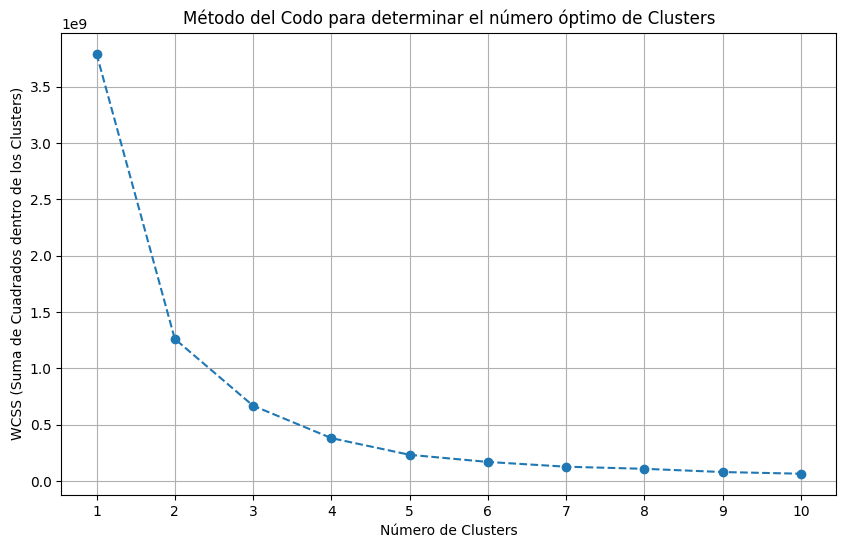


 La cantidad de clusteres debe ser 3


In [211]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(df_imputed)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS (Suma de Cuadrados dentro de los Clusters)')
plt.title('Método del Codo para determinar el número óptimo de Clusters')
plt.xticks(np.arange(1, 11, 1))
plt.grid(True)
plt.show()    


localizador_codo = KneeLocator(range(1, 11), wcss, curve = 'convex', direction = "decreasing")
print(f"\n La cantidad de clusteres debe ser {localizador_codo.elbow}")

In [240]:
categoricas_originales = ['VIC_REL_AGR', 'CONTEXTO_DE_VIC','MEDIDAS_SEGURIDAD', 'HEC_RECUR_DENUN',
                          'HAY_HIJOS', 'HAY_HIJOS_HOM', 'HAY_HIJOS_MUJ',
                          'HAY_OTRAS_VIC', 'HAY_OTRAS_VIC_HOM_MENORES',
                          'HAY_OTRAS_VIC_MUJ_MENORES', 'HAY_OTROS_AGR','TipoAgre_física',	'TipoAgre_patrimonial',	'TipoAgre_psicológica',	'TipoAgre_sexual']

df_orig = nuevo_df[categoricas_originales]
agre_orig = df['HEC_TIPAGRE']
fechas_imputed = df_imputed[['FECHA_ENTRE_EMISION_HECHO']]
gauge_df = pd.concat([df_orig,agre_orig,fechas_imputed], axis=1)
gauge_df.head()



,VIC_REL_AGR,CONTEXTO_DE_VIC,MEDIDAS_SEGURIDAD,HEC_RECUR_DENUN,HAY_HIJOS,HAY_HIJOS_HOM,HAY_HIJOS_MUJ,HAY_OTRAS_VIC,HAY_OTRAS_VIC_HOM_MENORES,HAY_OTRAS_VIC_MUJ_MENORES,HAY_OTROS_AGR,TipoAgre_física,TipoAgre_patrimonial,TipoAgre_psicológica,TipoAgre_sexual,HEC_TIPAGRE,FECHA_ENTRE_EMISION_HECHO
0,Esposos(a),2,Dto. 22-2008,No,No,No,No,Si,Si,Si,Si,1,0,1,0,"[física, psicológica]",3.0
1,Conviviente,2,Dto. 22-2008,No,No,Si,No,Desconocido,Desconocido,Desconocido,Desconocido,1,1,1,0,"[física, psicológica, patrimonial]",1.0
2,Ex-cónyuges,1,Dto. 22-2008,No,No,No,No,No,No,No,Desconocido,1,1,1,0,"[física, psicológica, patrimonial]",0.0
3,Esposos(a),3,Dto. 97-96,No,Si,Si,Si,Si,Si,Si,Desconocido,0,0,1,0,[psicológica],0.0
4,Esposos(a),2,Dto. 22-2008,No,Desconocido,Desconocido,Desconocido,No,No,Si,Desconocido,0,1,1,1,"[psicológica, sexual, patrimonial]",0.0


In [261]:
k = 3

kmeans = KMeans
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(df_imputed)
clusters = kmeans.labels_

gauge_df['GAUGE_CLUSTER'] = clusters
df_imputed['GAUGE_CLUSTER'] = clusters
gauge_df.head()

,VIC_REL_AGR,CONTEXTO_DE_VIC,MEDIDAS_SEGURIDAD,HEC_RECUR_DENUN,HAY_HIJOS,HAY_HIJOS_HOM,HAY_HIJOS_MUJ,HAY_OTRAS_VIC,HAY_OTRAS_VIC_HOM_MENORES,HAY_OTRAS_VIC_MUJ_MENORES,HAY_OTROS_AGR,TipoAgre_física,TipoAgre_patrimonial,TipoAgre_psicológica,TipoAgre_sexual,HEC_TIPAGRE,FECHA_ENTRE_EMISION_HECHO,GAUGE_CLUSTER
0,Esposos(a),2,Dto. 22-2008,No,No,No,No,Si,Si,Si,Si,1,0,1,0,"[física, psicológica]",3.0,0
1,Conviviente,2,Dto. 22-2008,No,No,Si,No,Desconocido,Desconocido,Desconocido,Desconocido,1,1,1,0,"[física, psicológica, patrimonial]",1.0,0
2,Ex-cónyuges,1,Dto. 22-2008,No,No,No,No,No,No,No,Desconocido,1,1,1,0,"[física, psicológica, patrimonial]",0.0,0
3,Esposos(a),3,Dto. 97-96,No,Si,Si,Si,Si,Si,Si,Desconocido,0,0,1,0,[psicológica],0.0,0
4,Esposos(a),2,Dto. 22-2008,No,Desconocido,Desconocido,Desconocido,No,No,Si,Desconocido,0,1,1,1,"[psicológica, sexual, patrimonial]",0.0,0


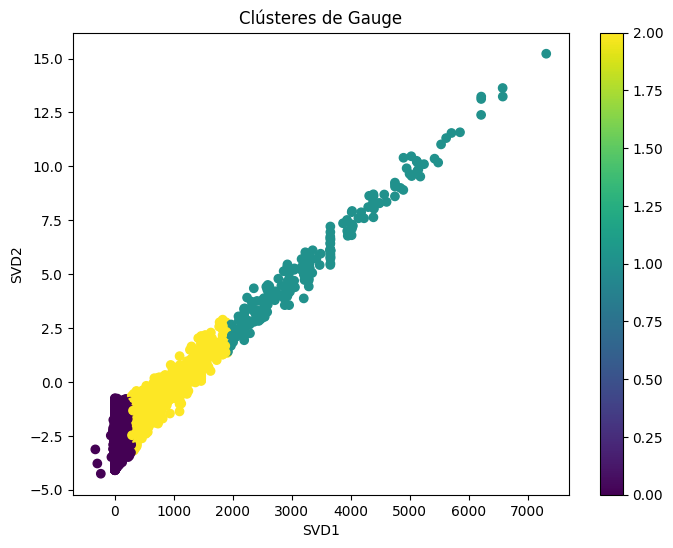

In [262]:
svd = TruncatedSVD(n_components=2)
gauge_2D = svd.fit_transform(df_imputed)

pca_df = pd.DataFrame(data=gauge_2D, columns=['SVD1', 'SVD2'])
pca_df['cluster'] = clusters

plt.figure(figsize=(8, 6))
plt.scatter(pca_df['SVD1'], pca_df['SVD2'], c=pca_df['cluster'], cmap='viridis')
plt.xlabel('SVD1')
plt.ylabel('SVD2')
plt.title('Clústeres de Gauge')
plt.colorbar()
plt.show()

# Analisis de Clusters

## Cluster 0

In [263]:
cluster_0 = gauge_df[gauge_df['GAUGE_CLUSTER'] == 0]
print(f"Hay {cluster_0.count()[0]} casos en el Cluster 0") 
for columna in gauge_df.columns:
    print(cluster_0[columna].value_counts())
    print("\n")

Hay 317331 casos en el Cluster 0
VIC_REL_AGR
Conviviente      96236
Esposos(a)       94478
Ex-cónyuges      49940
Otro pariente    32099
Hermanos(as)     16929
Padres/madres    14735
Hijos(as)         6450
Suegros(as)       4959
Hijastros(as)     1097
Nietos(as)         408
Name: count, dtype: int64


CONTEXTO_DE_VIC
1    145132
2     87026
0     62059
3     23114
Name: count, dtype: int64


MEDIDAS_SEGURIDAD
Dto. 22-2008     250613
Dto. 97-96        56139
Dto. 27-20033     10579
Name: count, dtype: int64


HEC_RECUR_DENUN
No          271456
Si           35427
Ignorado     10448
Name: count, dtype: int64


HAY_HIJOS
No             222731
Desconocido     58489
Si              36111
Name: count, dtype: int64


HAY_HIJOS_HOM
No             170255
Si              88587
Desconocido     58489
Name: count, dtype: int64


HAY_HIJOS_MUJ
No             161074
Si              97775
Desconocido     58482
Name: count, dtype: int64


HAY_OTRAS_VIC
Desconocido    120652
Si             114226
No      

/var/folders/2s/j3vn9g1d48b630yqb51x1d740000gn/T/ipykernel_66802/710150899.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Hay {cluster_0.count()[0]} casos en el Cluster 0")


El cluster 0 contiene la mayor proporción de casos, siendo esta 316,819 casos, estos casos involucran agresores convivientes de la victima y de relación matrimonial. Las víctimas de estos casos tienen un contexto de vida 1 y 2, considerandas en un rango de edad de 20 a 40 años con estudios. En la mayoría son casos sin recurrencia y no hay hijos.

Estas son víctimas de violencia psicologica, esta ocurre comunmente con violencia fisica

## Cluster 1


In [264]:
cluster_1 = gauge_df[gauge_df['GAUGE_CLUSTER'] == 1]
print(f"Hay {cluster_1.count()[0]} casos en el Cluster 1 \n") 
for columna in gauge_df.columns:
    print(cluster_1[columna].value_counts())
    print("\n")

Hay 231 casos en el Cluster 1 

VIC_REL_AGR
Ex-cónyuges      71
Esposos(a)       69
Conviviente      45
Otro pariente    27
Padres/madres     7
Hijos(as)         5
Hermanos(as)      3
Suegros(as)       2
Nietos(as)        1
Hijastros(as)     1
Name: count, dtype: int64


CONTEXTO_DE_VIC
2    104
1     80
0     28
3     19
Name: count, dtype: int64


MEDIDAS_SEGURIDAD
Dto. 22-2008     210
Dto. 97-96        18
Dto. 27-20033      3
Name: count, dtype: int64


HEC_RECUR_DENUN
No          178
Si           33
Ignorado     20
Name: count, dtype: int64


HAY_HIJOS
No             176
Desconocido     37
Si              18
Name: count, dtype: int64


HAY_HIJOS_HOM
No             128
Si              66
Desconocido     37
Name: count, dtype: int64


HAY_HIJOS_MUJ
No             119
Si              75
Desconocido     37
Name: count, dtype: int64


HAY_OTRAS_VIC
Desconocido    99
No             95
Si             37
Name: count, dtype: int64


HAY_OTRAS_VIC_HOM_MENORES
Desconocido    99
Si            

/var/folders/2s/j3vn9g1d48b630yqb51x1d740000gn/T/ipykernel_66802/3123230257.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Hay {cluster_1.count()[0]} casos en el Cluster 1 \n")


El cluster 1 contiene la menor proporción de casos, siendo esta 231 casos, estos casos involucran agresores en una relacion matrimonial, ex-conyuges en su mayoria. Las víctimas de estos casos tienen un contexto 2, considerandas en un rango de edad de 30 a 40 años con estudios. En la mayoría son casos sin recurrencia y no hay hijos.

Estas son víctimas de violencia patrimonial, esta ocurre comunmente con violencia psicologica

## Cluster 2

In [265]:
cluster_2 = gauge_df[gauge_df['GAUGE_CLUSTER'] == 2]
print(f"Hay {cluster_2.count()[0]} casos en el Cluster 2 \n") 
for columna in gauge_df.columns:
    print(cluster_2[columna].value_counts())
    print("\n")

Hay 2216 casos en el Cluster 2 

VIC_REL_AGR
Esposos(a)       680
Ex-cónyuges      543
Conviviente      507
Otro pariente    233
Hermanos(as)      95
Padres/madres     75
Hijos(as)         39
Suegros(as)       28
Hijastros(as)     11
Nietos(as)         5
Name: count, dtype: int64


CONTEXTO_DE_VIC
1    902
2    800
0    339
3    175
Name: count, dtype: int64


MEDIDAS_SEGURIDAD
Dto. 22-2008     1801
Dto. 97-96        322
Dto. 27-20033      93
Name: count, dtype: int64


HEC_RECUR_DENUN
No          1704
Si           363
Ignorado     149
Name: count, dtype: int64


HAY_HIJOS
No             1617
Desconocido     395
Si              204
Name: count, dtype: int64


HAY_HIJOS_HOM
No             1212
Si              609
Desconocido     395
Name: count, dtype: int64


HAY_HIJOS_MUJ
No             1140
Si              681
Desconocido     395
Name: count, dtype: int64


HAY_OTRAS_VIC
Desconocido    926
No             730
Si             560
Name: count, dtype: int64


HAY_OTRAS_VIC_HOM_MENORES
Des

/var/folders/2s/j3vn9g1d48b630yqb51x1d740000gn/T/ipykernel_66802/3996532556.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Hay {cluster_2.count()[0]} casos en el Cluster 2 \n")


El cluster 2 contiene 2216 casos, estos casos involucran agresores en una relacion de relacion matrimonial. Las víctimas de estos casos tienen un contexto 2, considerandas en un rango de edad de 30 a 40 años con estudios. En la mayoría son casos sin recurrencia y no hay hijos.

Estas son víctimas de violencia psicologica, esta ocurre comunmente con violencia fisica

In [251]:
cluster_3 = gauge_df[gauge_df['GAUGE_CLUSTER'] == 3]
print(f"Hay {cluster_3.count()[0]} casos en el Cluster 3 \n") 
for columna in gauge_df.columns:
    print(cluster_3[columna].value_counts())
    print("\n")

Hay 116 casos en el Cluster 3 

VIC_REL_AGR
Esposos(a)       35
Ex-cónyuges      30
Conviviente      28
Otro pariente    12
Hijos(as)         4
Hermanos(as)      3
Padres/madres     2
Suegros(as)       2
Name: count, dtype: int64


CONTEXTO_DE_VIC
2    49
1    42
0    17
3     8
Name: count, dtype: int64


MEDIDAS_SEGURIDAD
Dto. 22-2008     106
Dto. 97-96         9
Dto. 27-20033      1
Name: count, dtype: int64


HEC_RECUR_DENUN
No          88
Si          16
Ignorado    12
Name: count, dtype: int64


HAY_HIJOS
No             88
Desconocido    17
Si             11
Name: count, dtype: int64


HAY_HIJOS_HOM
No             67
Si             32
Desconocido    17
Name: count, dtype: int64


HAY_HIJOS_MUJ
No             59
Si             40
Desconocido    17
Name: count, dtype: int64


HAY_OTRAS_VIC
Desconocido    52
No             46
Si             18
Name: count, dtype: int64


HAY_OTRAS_VIC_HOM_MENORES
Desconocido    52
Si             35
No             29
Name: count, dtype: int64


HAY_OT

/var/folders/2s/j3vn9g1d48b630yqb51x1d740000gn/T/ipykernel_66802/2246559118.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Hay {cluster_3.count()[0]} casos en el Cluster 3 \n")
